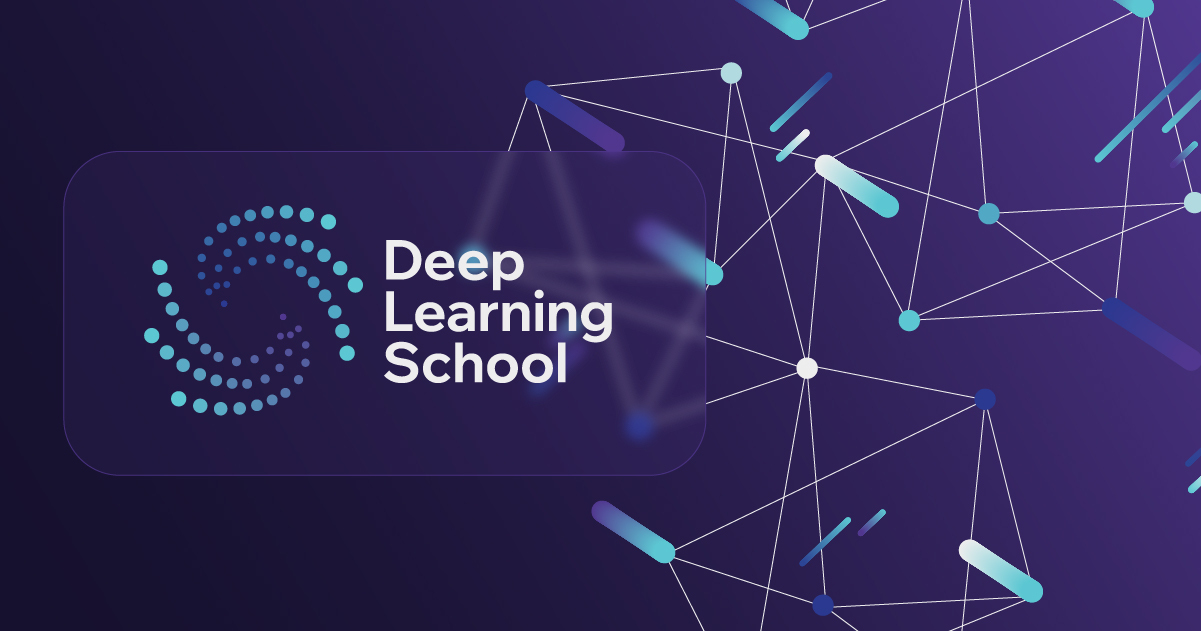

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [5]
  * backbone[1],
  * Neck [3],
  * Head [1]
* Label assignment [2]:
  * TAL [2]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.15 mAP [1]
  * 0.3 mAP  [2]
  * 0.6 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [ ]:
# Предварительные замечания:
# - часть функций(не все) я взял из семинарского ноутбука и использовал в качестве основы
# - часть ячеек полностью закомментированы(они использовались мной как вспомогательные, к результатам отношения не имеют, н-р просмотр датасета и т.п.)
# - поскольку блокнот довольно длинный и с большим числом ячеек и текста, то я посчитал уместным перенести вывод в начало.


# Вывод и результаты:
#
# 1) Лучший mAP, которого удалось добиться сравнительно скромен mAP(%) = 7.43, при этом
# потребовалось 300 эпох. Результат этого обучения представлен в ноутбуке как основной, в т.ч. примеры(картинки) тестовой выборки.
# При этом, модель довольно стабильно обучалась практически все эти 300 эпох, без существенного переобучения.
# После лога обучения выведено несколько тестовых изображений, где видно что модель в принципе научилась определять
# персонажей, а также находить их головы(не идеально, но все же).
#
# 2) Обучение с применением assign_target дало этот лучший результат, результат TAL_assigner - заметно
# хуже(результат представлен в конце ноутбука). Думаю, это связано с тем, что TAL_assigner сложнее, т.к. учитывает
# выравнивание классификации и локализации, которые я в полной мере не смог реализовать(изучить и
# применить), но вообще TAL_assigner конечно д.б. лучше, особенно учитывая пересечение ббоксов и их
# возможную "разноразмерность".
#
# 3) Наибольший вклад конкретно в мой результат внесло большое количество эпох (это 100%) и разморозка
# слоев в бэкбоне. Думаю, что вообще говоря, это  неочень хорошо(кажется нужно былобы сосредоточиться на
# размерности якорей и их обработке на фичемапах и в декодере).
#
# 4) Изменения головы и шеи практически не вносили изменений в метрику(в моих опытах). Точнее, это либо
# сильно усложняло модель и часто вызывало OutOfMemory/краш сессии, либо требовало дополнительных
# настроек работы с якорями, что в свою очередь требовало бОльшего числа отладочных запусков(но кажется в
# этом и был ключ).


In [ ]:
# Для каггла
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 6.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.4
    Uninstalling albumentations-2.0.4:
      Successfully uninstalled albumentations-2.0.4


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9

In [ ]:
import torch
import numpy as np
import pandas as pd
import albumentations as A

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
import math
from functools import partial
from collections import Counter, defaultdict

import io
import cv2
import matplotlib.pyplot as plt

import timm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.ops import nms, box_iou
from torchvision.models.detection.anchor_utils import AnchorGenerator

from torchmetrics.detection import MeanAveragePrecision

In [ ]:
# Определяем константы для цвета и названий классов
class_to_color = {
    1: (89, 161, 197),
    2: (204, 79, 135),
    3: (125, 216, 93),
    4: (175, 203, 33),
}

class_to_name = {
    1 : "enemy",
    2 : "enemy-head",
    3 : "friendly",
    4 : "friendly-head"
}

In [ ]:
# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, label='', color=(128, 128, 128), txt_color=(0, 0, 0)):
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[0]) + int(box[2]), int(box[1]) + int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
    if label:
        tf = max(lw - 1, 1)
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)
        cv2.putText(image,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)
    return image

def plot_examples(df, indices=None, num_examples=6, row_figsize=(12, 3)):
    if indices is None:
        indices = np.random.choice(len(df), size=num_examples, replace=False)
    else:
        num_examples = len(indices)
    ncols = min(num_examples, 3)
    nrows = math.ceil(num_examples / 3)
    _, axes = plt.subplots(nrows, ncols, figsize=(row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)
    for ix, ax in zip(indices, axes):
        row = df.iloc[ix]
        image = Image.open(io.BytesIO(row['image']['bytes']))
        bboxes = row["objects"]['bbox']
        classes = row["objects"]['category']
        img = np.array(image)
        for bbox, label in zip(bboxes, classes):
            color = class_to_color[label]
            class_name = class_to_name[label]
            img = add_bbox(img, bbox, label=str(class_name), color=color)
        ax.imshow(img)
        ax.set_title(f"Image id: {row['image_id']}")
        ax.set_xticks([])
        ax.set_yticks([])

### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [ ]:
splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

In [ ]:
# Выведем пример данных
df_train.head()

,image_id,image,width,height,objects
0,311,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [573, 574], 'area': [1748, 15756], 'bbo..."
1,67,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [137, 138], 'area': [14136, 88392], 'bb..."
2,161,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [301, 302], 'area': [3016, 33768], 'bbo..."
3,210,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [379, 380], 'area': [832, 9248], 'bbox'..."
4,142,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [272, 273], 'area': [1520, 16704], 'bbo..."


In [ ]:
# Несколько примеров картинок из обучающей выборки
# plot_examples(df_train)

In [ ]:
# Несколько примеров картинок из тестовой выборки
# plot_examples(df_test)

Создаем датасет для предобработки данных

In [ ]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df_objects = pd.json_normalize(dataframe['objects'])[["bbox", "category"]]
        df_images = pd.json_normalize(dataframe['image'])[["bytes"]]
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        labels: List[int] Набор классов для каждого ббокса,
        boxes: List[List[int]] Набор ббоксов в формате (x_min, y_min, w, h).
        """
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row["bytes"]))
        image = np.array(image)

        target = {}
        target["image_id"] = row["image_id"]

        labels = [row["category"]] if isinstance(row["category"], int) else row['category']
        # Вычитаем единицу чтобы классы начинались с нуля
        labels = [label - 1 for label in labels]
        boxes = row['bbox'].tolist()

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        target['boxes'] = torch.tensor(np.array(boxes), dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        return image, target

def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

Тут можно написать любые аугментации

In [ ]:
# Аугментация

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# # Вариант из семинара
# mean = (0.485, 0.456, 0.406)
# std = (0.229, 0.224, 0.225)
#
# train_transform = A.Compose(
#     [
#         A.Normalize(mean=mean, std=std),
#         # HorizontalFlip меняет и ббоксы!
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(p=0.2),
#         ToTensorV2(),
#     ],
#     bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
# )
#
# test_transform = A.Compose(
#     [
#         A.Normalize(mean=mean, std=std),
#         ToTensorV2(),
#     ]
# )


mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.Normalize(mean=mean, std=std),
    A.OneOf([
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3)
    ], p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=10, p=0.3),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

Не забываем инициализировать наш датасет

In [ ]:
train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)

## Переделываем модель [5 баллов]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать.

### Backbone [1 балл]

В лекции мы заморозили все слои у модели. Вам нужно написать бекбоун с возможностью разморозки __k__ последних слоев или блоков (на ваш выбор).

In [ ]:
# Backbone


# # Вариант из семинара
# class Backbone(nn.Module):
#     def __init__(self, model_name="efficientnet_b0", out_indices=(-1, -2, -3)):
#         super().__init__()
#         # timm.list_models(pretrained=True)
#         self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=out_indices)
#         # Выключаем градиенты у модели, чтобы упростить обучение
#         for param in self.backbone.parameters():
#             param.requires_grad = False

#     def forward(self, x):
#         return self.backbone(x)

# # Разморозим несколько последних слоев
class Backbone(nn.Module):
    def __init__(self, model_name="efficientnet_b0", out_indices=(-1, -2, -3), freeze_n_layers=208):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=out_indices)

        for i, param in enumerate(self.backbone.parameters()):
            param.requires_grad = (i >= freeze_n_layers)

        trainable = sum(1 for p in self.backbone.parameters() if p.requires_grad)

    def forward(self, x):
        return self.backbone(x)


### NECK [3 балла]

Вам предлагается на выбор написать одну из двух шей:

#### Feature Pyramid Network [2 балла]

Знакомая из лекции архитектура шеи:

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

#### Path Aggregation Network [3 балла]

Другая архитектура немного сложнее. Она содержит не только top-down путь, но ещё bottom-up путь:

<center><img src="https://i.ibb.co/k68BWBGv/path-aggregation-network.png" width="500"/></center>

* [Path Aggregation Network for Instance Segmentation](https://arxiv.org/abs/1803.01534)

Подробное описание архитектуры можно найти в секции 3 (Framework). Реализовывать adaptive feature pooling не нужно.


__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели,
* Также, можно добавить доп конволюцию (3х3 с паддингом) у каждого выхода шеи.

In [ ]:
# # Вариант из семинара
class SimplifiedFPN(nn.Module):
    """Очень простая шея: один слой conv + batch_norm + activation. """
    def __init__(self, in_channels, out_channels, use_activations=True):
        super().__init__()
        self.fpn_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.activation = nn.ReLU() if use_activations else nn.Identity()
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, features):
        return self.activation(self.bn(self.fpn_conv(features[0])))

# # С усложнением
# class EnhancedFPN(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         # добавим несколько уровней агрегации признаков
#         self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
#         self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
#         self.downsample = nn.MaxPool2d(2)
#         self.attention = nn.Sequential(
#             nn.Conv2d(out_channels, 1, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, features):
#         x = F.relu(self.conv1(features[0]))
#         x = F.relu(self.conv2(x))
#         attn = self.attention(x)
#         return x * attn

### Head [1 балл]

В качестве шеи можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center><img src="https://i.ibb.co/BVtBR2R3/Decoupled-head.jpg"/></center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса!

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

In [ ]:
# Вариант из семинара
class DetectionHead(nn.Module):
    """ Двухсоставная голова, схематично выглядит следующим образом:
                      -> conv (cls) [B, NUM_ANCHORS * NUM_CLASSES, W, H]
        neck -> conv
                      -> conv (reg) [B, NUM_ACNHORS * 5, W, H]
    где число 5 обозначает 4 смещения для итогового + confidence score.
    """
    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.cls_head = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=1)
        self.reg_head = nn.Conv2d(in_channels, num_anchors * 5, kernel_size=1)
        self.num_classes = num_classes

    def forward(self, x):
        x = F.relu(self.conv(x))
        cls_logits = self.cls_head(x)
        bbox_preds = self.reg_head(x)
        return cls_logits, bbox_preds

# # С изменениями
# class DetectionHead(nn.Module):
#     def __init__(self, in_channels, num_anchors, num_classes):
#         super().__init__()
#         self.cls_conv = nn.Sequential(
#             nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(in_channels),
#             nn.ReLU()
#         )
#         self.reg_conv = nn.Sequential(
#             nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(in_channels),
#             nn.ReLU()
#         )
#         self.cls_head = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=1)
#         self.reg_head = nn.Conv2d(in_channels, num_anchors * 5, kernel_size=1)
#         self.num_classes = num_classes

#     def forward(self, x):
#         cls_features = self.cls_conv(x)
#         reg_features = self.reg_conv(x)
#         cls_logits = self.cls_head(cls_features)
#         bbox_preds = self.reg_head(reg_features)
#         return cls_logits, bbox_preds

Теперь можно снова реализовать класс детектора с учетом всех частей выше!

In [ ]:
class Detector(nn.Module):
    """ Класс детектора, объединяющий все части вместе.

    Параметры
    ---------
    backbone_model_name : str
        Имя timm модели, которая будет исопльзоваться в качестве backbone
    neck_n_channels : int
        Итоговое количество каналов на выходе шеи
    num_classes : int
        Количество классов в датасете
    anchor_sizes : list, tuple
        Базовые размеры якорей. Используется методом `AnchorDetector` из
        `torchvision.models.detection.anchor_utils`для создания якорей.
    anchor_ratios : list, tuple
        Соотношения сторон якорей. Используется методом `AnchorDetector` из
        `torchvision.models.detection.anchor_utils`для создания якорей.
    input_size : tuple with length 2
        Размер входного изображения. Используется для расчета положения всех якорей.

    NOTE: На самом деле, AnchorDetector на вход ждет anchor_sizes и anchor_ratios как Tuple[Tuple[int]],
    это связано с возможностью создания разных якорей для разных выходов модели. Сейчас нам это не нужно,
    поэтому структура намеренно упрощена.
    """
    def __init__(self,
                 backbone_model_name="efficientnet_b0",
                 neck_n_channels=256,
                 num_classes=4,
                 anchor_sizes=(32, 64, 128),
                 anchor_ratios=(0.5, 1.0, 2.0),
                 # anchor_sizes=(16, 32, 64),
                 # anchor_ratios=(0.3, 0.5, 1.0),
                 input_size=(640, 640),
        ):
        super().__init__()
        self.num_classes = num_classes

        # Создаем backbone с одним выходом, только из последнего слоя
        # Если нужно сделать несколько выходов, меняй out_indices
        self.backbone = Backbone(backbone_model_name, out_indices=(-1, ))

        # Получаем количество фичемапов на выходном слое
        in_channels = self.backbone.backbone.feature_info.channels()[0]

        # Создаем шею, с учетом параметров, полученных выше
        self.neck = SimplifiedFPN(in_channels, out_channels=neck_n_channels)
        # self.neck = EnhancedFPN(in_channels, out_channels=neck_n_channels)

        # Размерность выходов головы зависит от количество якорей, поэтому сначала считаем количество якорей в каждой
        # ячейке выходной фичемапы
        num_anchors = len(anchor_sizes) * len(anchor_ratios)
        self.head = DetectionHead(in_channels=neck_n_channels, num_anchors=num_anchors, num_classes=num_classes)

        # Генерируем якоря
        anchor_generator = AnchorGenerator(sizes=(anchor_sizes, ), aspect_ratios=(anchor_ratios, ))
        # anchor_generator = AnchorGenerator(
        #   sizes=tuple((s,) for s in anchor_sizes),
        #   aspect_ratios=(anchor_ratios,)*4
        # )


        # Узнаем размер выходной фичемапы
        reduction = self.backbone.backbone.feature_info.reduction()[0]
        grid_sizes = [[input_size[0] // reduction, input_size[1] // reduction]]

        # Расчитываем координаты якорей в каждой точке выходной фичемапы.
        ###
        # Якоря хранятся в формате (x_min, y_min, x_max, y_max)!
        ###
        anchors = anchor_generator.grid_anchors(grid_sizes, strides=[[reduction, reduction]])
        anchors = torch.stack(anchors, dim=0)

        # Заранее считаем координаты якорей в формате (x_center, y_center, w, h)
        # Это пригодится для расчета лосса
        anchor_centers = (anchors[:, :, :2] + anchors[:, :, 2:]) / 2
        anchor_sizes = (anchors[:, :, 2:] - anchors[:, :, :2])

        self.register_buffer("anchors", anchors)
        self.register_buffer("anchor_centers", anchor_centers)
        self.register_buffer("anchor_sizes", anchor_sizes)

    def forward(self, x):
        # Пропускаем картинку через всю сеть
        features = self.backbone(x)
        neck_features = self.neck(features)
        cls_logits, bbox_preds = self.head(neck_features)

        # Преобразуем сырые выходы модели в формат, в котором будет удобно считать лосс
        # cls_logits - [N, NUM_ANCHORS * NUM_CLASSES, W, H]
        # bbox_preds - [N, NUM_ANCHORS * 5, W, H]
        N = x.shape[0]
        cls_logits = cls_logits.permute(0, 2, 3, 1).contiguous()
        cls_logits = cls_logits.view(N, -1, self.head.num_classes) # [N, NUM_ANCHORS * W * H, NUM_CLASSES]

        bbox_preds = bbox_preds.permute(0, 2, 3, 1).contiguous()
        bbox_preds = bbox_preds.view(N, -1, 5) # [N, NUM_ANCHORS * W * H, 5]
        bbox_offsets = bbox_preds[:, :, :4]
        confidence_logits = bbox_preds[:, :, 4]

        if self.training:
            # В процессе тренировки возвращаем просто смещения и логиты
            return bbox_offsets, confidence_logits, cls_logits

        # Если мы делаем предсказание, сразу считаем итоговый ббокс и вероятности
        # Модель предсказывает ббоксы в формате (x_min, y_min, w, h)
        bboxes = self.decode_bboxes(bbox_offsets)
        confidence = torch.sigmoid(confidence_logits)
        cls_probs = torch.softmax(cls_logits, dim=-1)
        return bboxes, confidence, cls_probs


    def decode_bboxes(self, bbox_offsets):
        """Используя предсказанные смещения, считаем предсказанные ббоксы по формулам из YOLOv3.

        Боксы возвращаются в формате (x_min, y_min, w, h).
        """
        tx = bbox_offsets[:, :, 0]
        ty = bbox_offsets[:, :, 1]
        tw = bbox_offsets[:, :, 2]
        th = bbox_offsets[:, :, 3]

        center_x = self.anchor_centers[:, :, 0] + torch.sigmoid(tx) * self.anchor_sizes[:, :, 0]
        center_y = self.anchor_centers[:, :, 1] + torch.sigmoid(ty) * self.anchor_sizes[:, :, 1]

        w = torch.exp(tw) * self.anchor_sizes[:, :, 0]
        h = torch.exp(th) * self.anchor_sizes[:, :, 1]

        x_min = center_x - w / 2
        y_min = center_y - h / 2
        return torch.stack([x_min, y_min, w, h], dim=-1)


In [ ]:
# TRAINING

def safe_logit(x):
    """ Безопасный расчет logit'ов. """
    eps = 1e-6
    x = torch.clamp(x, eps, 1 - eps)
    return torch.log(x / (1 - x))

def get_target_offset(anchor_box, gt_box):
    """ Расчитываем таргет как желаемые смещения от якорей до GT.

    anchor_box: torch.Tensor в формате (x_min, y_min, x_max, y_max),
    gt_box: torch.Tensor в формате (x_min, y_min, x_max, y_max).
    """
    # Конвертируем GT в формат (x_center, y_center), (w, h)
    gt_center = (gt_box[:2] + gt_box[2:]) / 2
    gt_size = gt_box[2:] - gt_box[:2]

    # Конвертируем якоря в формат (x_center, y_center), (w, h)
    anchor_center = (anchor_box[:2] + anchor_box[2:]) / 2
    anchor_size = anchor_box[2:] - anchor_box[:2]

    # Вычисляем значения смещений для положительных ббоксов
    tx = (gt_center[0] - anchor_center[0]) / anchor_size[0]
    ty = (gt_center[1] - anchor_center[1]) / anchor_size[1]
    target_tx = safe_logit(tx)
    target_ty = safe_logit(ty)

    target_tw = torch.log(gt_size[0] / anchor_size[0])
    target_th = torch.log(gt_size[1] / anchor_size[1])
    return torch.tensor([target_tx, target_ty, target_tw, target_th]).to(anchor_box.device)

# Label assignment

In [ ]:
# Функция из из семинара. Следом(в след.ячейке будет TAL_assigner.
def assign_target(anchors, gt_boxes, gt_labels, num_classes, pos_th=0.6, neg_th=0.3):
    """ Для каждого GT находим якоря, которые будут участвовать в расчете лосса по следующему алгоритму:
    1. Положительные якоря - якоря у которых IoU с GT >= `pos_th`,
    2. Игнорируемые якоря - `neg_th` <= IoU c GT < `pos_th`,
    3. Отрицательные якоря - IoU c GT < `neg_th`.
    4. Если для GT не нашлось ни одного якоря, назначаем GT якорь с самым большим IoU.

    Параметры
    ---------
    anchors : list[list[float]]
        Набор якорей для выходной фичемапы, размер (NUM_ANCHORS * W * H, 4)
    gt_boxes : list[list[float]]
        Набор истинных ббоксов на изображении, размер (N_GT, 4)
    gt_labels : list[int]
        Набор лейблов для GT, размер (N_GT, )
    num_classes : int
        Количество классов в датасете
    pos_th : float
        Минимальная граница по IoU между якорем и GT после которой якорь считается положительным.
    neg_th : float
        Верхняя граница по IoU между якорем и GT когда якорь считается отрицательным.

    Returns
    -------
    target_offsets: Массив, содержащий истинные смещения для положительных якорей, 0 для всех остальных
    target_objectness: Массив, содержащий тип каждого якоря (1 - положительный, 0 - отрицательный, -1 - игнорируемый)
    target_cls: Массив, содержащий ohe классы для каждого якоря. Для всех, кроме положительных якорей, класс не указан.
    """
    num_anchors = anchors.shape[0]
    target_objectness = torch.zeros(num_anchors, device=anchors.device)
    target_offsets = torch.zeros((num_anchors, 4), device=anchors.device)
    target_cls = torch.zeros((num_anchors, num_classes), device=anchors.device)

    # Если на изображении нет объектов, возвращаем пустые списки
    if gt_boxes.numel() == 0:
        return target_offsets, target_objectness, target_cls

    # box_iou работает с форматом ббоксов (x_min, y_min, x_max, y_max)
    # Якоря находятся в нужном формате, а GT - нет, тк имеет формат (x_min, y_min, w, h)
    # Переведем GT боксы в нужный формат
    gt_xyxy = gt_boxes.clone()
    gt_xyxy[:, 2:] = gt_xyxy[:, :2] + gt_xyxy[:, 2:]

    # Считаем iou между всеми якорями и всеми GT
    ious = box_iou(anchors, gt_xyxy) # [num_anchors, num_gt]

    # Находим самый оптимальный GT для каждого якоря
    best_iou, best_gt_idx = ious.max(dim=1)

    # Отмечаем якоря, которые будут пропущены при расчете лосса
    ignore_mask = (best_iou >= neg_th) & (best_iou < pos_th)
    target_objectness[ignore_mask] = -1

    # Отмечаем якоря, для которых будет считаться локализационный лосс
    pos_mask = best_iou >= pos_th
    pos_indices = pos_mask.nonzero(as_tuple=True)[0]
    for pos in pos_indices:
        gt_idx = best_gt_idx[pos]
        gt_box = gt_xyxy[gt_idx]
        anchor_box = anchors[pos]

        target_offsets[pos] = get_target_offset(anchor_box, gt_box)
        target_objectness[pos] = 1
        target_cls[pos, gt_labels[gt_idx]] = 1

    # Присваиваем предсказание с самым большим IoU для GT
    # у которых не нашлось ни оного предсказания
    for gt_idx in range(gt_xyxy.shape[0]):
        if not((target_objectness == 1) & (best_gt_idx == gt_idx)).any():
            best_anchor_idx = torch.argmax(ious[:, gt_idx])
            target_offsets[best_anchor_idx] = get_target_offset(anchors[best_anchor_idx], gt_xyxy[gt_idx])
            target_objectness[best_anchor_idx] = 1
            target_cls[best_anchor_idx, gt_labels[gt_idx]] = 1
    return target_offsets, target_objectness, target_cls

In [ ]:
from torchvision.ops import box_iou

def TAL_assigner(anchors, gt_boxes, gt_labels, cls_logits, num_classes, alpha=6.0, beta=1.0, top_k=5, neg_th=0.4, pos_th=0.6):
    """
    Назначение якорей для GT боксов с использованием Task Alignment Learning (TAL).

    Параметры
    ---------
    anchors : torch.Tensor
        Набор якорей для выходной фичемапы, размер (NUM_ANCHORS * W * H, 4), формат (x_min, y_min, x_max, y_max).
    gt_boxes : torch.Tensor
        Набор истинных боксов на изображении, размер (N_GT, 4), формат (x_min, y_min, w, h).
    gt_labels : torch.Tensor
        Набор меток для GT, размер (N_GT, ).
    cls_logits : torch.Tensor
        Логиты классификации для каждого якоря, размер (NUM_ANCHORS * W * H, NUM_CLASSES).
    num_classes : int
        Количество классов в датасете.
    alpha : float
        Степень для classification score в метрике TAL.
    beta : float
        Степень для IoU в метрике TAL.
    top_k : int
        Количество положительных якорей для каждого GT.
    neg_th : float
        Порог IoU для отрицательных якорей.
    pos_th : float
        Порог IoU для положительных якорей (используется для игнорируемых якорей).

    Returns
    -------
    target_offsets : torch.Tensor
        Истинные смещения для положительных якорей, размер (NUM_ANCHORS * W * H, 4).
    target_objectness : torch.Tensor
        Тип каждого якоря (1 - положительный, 0 - отрицательный, -1 - игнорируемый), размер (NUM_ANCHORS * W * H,).
    target_cls : torch.Tensor
        One-hot классы для каждого якоря, размер (NUM_ANCHORS * W * H, NUM_CLASSES).
    """
    num_anchors = anchors.shape[0]
    device = anchors.device

    # Инициализация выходных тензоров
    target_objectness = torch.zeros(num_anchors, device=device)
    target_offsets = torch.zeros((num_anchors, 4), device=device)
    target_cls = torch.zeros((num_anchors, num_classes), device=device)

    # Если нет GT боксов, возвращаем пустые тензоры
    if gt_boxes.numel() == 0:
        return target_offsets, target_objectness, target_cls

    # Преобразуем GT боксы в формат (x_min, y_min, x_max, y_max)
    gt_xyxy = gt_boxes.clone()
    gt_xyxy[:, 2:] = gt_xyxy[:, :2] + gt_xyxy[:, 2:]

    # Вычисляем IoU между всеми якорями и всеми GT
    ious = box_iou(anchors, gt_xyxy)  # [num_anchors, num_gt]

    # Фильтрация якорей: центры якорей должны быть внутри GT
    anchor_centers = (anchors[:, :2] + anchors[:, 2:]) / 2  # [num_anchors, 2]
    valid_anchors = torch.zeros(num_anchors, dtype=torch.bool, device=device)

    for gt_idx in range(gt_xyxy.shape[0]):
        gt = gt_xyxy[gt_idx]
        inside = (anchor_centers[:, 0] >= gt[0]) & (anchor_centers[:, 0] <= gt[2]) & \
                 (anchor_centers[:, 1] >= gt[1]) & (anchor_centers[:, 1] <= gt[3])
        valid_anchors |= inside

    # Ограничим ious только валидными якорями
    ious[~valid_anchors] = 0.0

    # Получаем classification scores из cls_logits
    cls_probs = torch.softmax(cls_logits, dim=-1)  # [num_anchors, num_classes]
    cls_scores = torch.zeros_like(ious, device=device)  # [num_anchors, num_gt]
    for gt_idx, label in enumerate(gt_labels):
        cls_scores[:, gt_idx] = cls_probs[:, label]  # Вероятность для GT класса

    # Вычисляем метрику TAL: t = s^alpha * u^beta
    metric = torch.pow(cls_scores, alpha) * torch.pow(ious, beta)  # [num_anchors, num_gt]

    # Для каждого GT выбираем top_k якорей
    pos_indices = []
    assigned_gt = []

    for gt_idx in range(gt_xyxy.shape[0]):
        gt_metric = metric[:, gt_idx]
        topk_values, topk_indices = torch.topk(gt_metric, k=min(top_k, valid_anchors.sum().item()), largest=True)
        valid_topk = topk_indices[topk_values > 0]  # Убедимся, что метрика ненулевая
        pos_indices.extend(valid_topk.tolist())
        assigned_gt.extend([gt_idx] * len(valid_topk))

    # Разрешение конфликтов: если якорь выбран для нескольких GT, выбираем GT с максимальным IoU
    if pos_indices:
        pos_indices = torch.tensor(pos_indices, device=device)
        assigned_gt = torch.tensor(assigned_gt, device=device)
        unique_pos_indices, counts = pos_indices.unique(return_counts=True)
        for anchor_idx in unique_pos_indices[counts > 1]:
            conflicting = (pos_indices == anchor_idx).nonzero(as_tuple=True)[0]
            gt_indices = assigned_gt[conflicting]
            iou_values = ious[anchor_idx, gt_indices]
            best_gt_idx = gt_indices[iou_values.argmax()]
            # Оставляем только лучший GT
            to_remove = conflicting[assigned_gt[conflicting] != best_gt_idx]
            pos_indices[to_remove] = -1
            assigned_gt[to_remove] = -1

        # Фильтруем удалённые якоря
        valid_mask = pos_indices >= 0
        pos_indices = pos_indices[valid_mask]
        assigned_gt = assigned_gt[valid_mask]

        # Назначаем положительные якоря
        for anchor_idx, gt_idx in zip(pos_indices, assigned_gt):
            gt_box = gt_xyxy[gt_idx]
            anchor_box = anchors[anchor_idx]
            target_offsets[anchor_idx] = get_target_offset(anchor_box, gt_box)
            target_objectness[anchor_idx] = 1
            target_cls[anchor_idx, gt_labels[gt_idx]] = 1

    # Назначаем игнорируемые и отрицательные якоря
    best_iou, _ = ious.max(dim=1)
    ignore_mask = (best_iou >= neg_th) & (best_iou < pos_th)
    target_objectness[ignore_mask] = -1
    # Отрицательные якоря уже имеют objectness = 0 по умолчанию

    return target_offsets, target_objectness, target_cls

In [ ]:
class ComputeLoss:
    """ Базовый расчет лосса.

    Параметры
    ---------
    bbox_loss : Локализационная часть лосса
    obj_loss : Лосс для Confidence score
    cls_loss : Классификационная часть лосса
    weight_bbox, weight_obj, weight_cls : Константы для баллансировки частей лосса
    """
    def __init__(self,
            bbox_loss=None, obj_loss=None, cls_loss=None,
            weight_bbox=5, weight_obj=1, weight_cls=1
        ):
        self.bbox_loss = nn.SmoothL1Loss() if bbox_loss is None else bbox_loss
        self.obj_loss = nn.BCEWithLogitsLoss() if obj_loss is None else obj_loss
        self.cls_loss = nn.BCEWithLogitsLoss() if cls_loss is None else cls_loss
        self.weight_bbox = weight_bbox
        self.weight_obj = weight_obj
        self.weight_cls = weight_cls

    def __call__(self, predicts, targets):
        """ Расчет лосса для пары (предсказание, таргет)

        Параметры
        ---------
        predicts : Предсказания модели для одной картинки: Смещения, objectness score и логиты для классов
        targets : Gt значения для расчета лосса, а именно: GT смещения, GT objectness score и GT ohe классы
        """
        pred_offsets, pred_obj_logits, pred_cls_logits = predicts
        target_boxes, target_obj, target_cls = targets
        # Confidence score считается только для предсказаний соотв отрицательным и положительным якорям
        valid_mask = target_obj != -1
        loss_obj = self.obj_loss(pred_obj_logits[valid_mask], target_obj[valid_mask])

        # Локализационная и классификационные части считаются для предсказаинй соотв положительным якорям
        pos_mask = target_obj == 1
        if pos_mask.sum() > 0:
            loss_cls = self.cls_loss(pred_cls_logits[pos_mask], target_cls[pos_mask])
            loss_bbox = self.bbox_loss(pred_offsets[pos_mask], target_boxes[pos_mask])
        else:
            loss_cls = torch.tensor(0.0, device=pred_offsets.device)
            loss_bbox = torch.tensor(0.0, device=pred_offsets.device)
        return self.weight_bbox * loss_bbox + self.weight_obj * loss_obj + self.weight_cls * loss_cls

In [ ]:
class Runner:
   def __init__(self, model, compute_loss, optimizer, train_dataloader, assign_target_method, device=None,
                 scheduler=None, assign_target_kwargs=None,
                 val_dataloader=None, val_every=5, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        assign_target_kwargs = {} if assign_target_kwargs is None else assign_target_kwargs
        self.assign_target_method = partial(assign_target_method, **assign_target_kwargs)
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        # Валидационные параметры
        self.val_dataloader = val_dataloader
        self.val_every = val_every
        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls

        # Вспомогательные массивы
        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []

    def _run_train_epoch(self, dataloader, verbose=True):
        """ Обучить модель одну эпоху на данных из `dataloader` """
        self.model.train()
        batch_loss = []
        for images, targets in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            outputs = self.model(images)

            anchors = self.model.anchors.view(-1, 4)
            accum_loss = 0.0
            for ix in range(images.shape[0]):
                gt_boxes = targets[ix]['boxes'].to(self.device)
                gt_labels = targets[ix]['labels'].to(self.device)

                # # выбираем какие якоря будут использоваться при расчете лосса.
                # assigned_targets = self.assign_target_method(anchors, gt_boxes, gt_labels,
                #                                              num_classes=model.num_classes)
                # Выбираем какие якоря будут использоваться при расчете лосса
                assigned_targets = self.assign_target_method(
                    anchors=anchors,
                    gt_boxes=gt_boxes,
                    gt_labels=gt_labels,
                    cls_logits=cls_logits,  # Передаём cls_logits для TAL
                    num_classes=self.model.num_classes

                # Считаем лосс на основании предсказаний модели и таргетов.
                outputs_ixs = [out[ix] for out in outputs]
                loss = self.compute_loss(outputs_ixs, assigned_targets)
                accum_loss += loss
            accum_loss = accum_loss / images.shape[0]
            batch_loss.append(accum_loss.cpu().detach().item())

            # Делаем шаг оптимизатора после расчета лосса для всех элементов батча
            self.optimizer.zero_grad()
            accum_loss.backward()
            self.optimizer.step()

            # Обновляем описание tqdm бара усредненным значением лосса за предыдущй батч
            if verbose:
                pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4}")
        return batch_loss

    def train(self, num_epochs=10, verbose=True):
        val_desc = ""
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))

            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                val_metric = self.validate()
                self.val_metric.append(val_metric)
                val_desc = f" Val {val_metric:.4}"

            # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.4}" + val_desc)
            # Делаем шаг scheduler'a если он был передан
            if self.scheduler is not None:
                self.scheduler.step()

    @torch.no_grad()
    def validate(self, dataloader=None):
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader

        # Считаем метрику mAP с помощью функции из torchmetrics
        metric = MeanAveragePrecision(box_format="xywh", iou_type="bbox")
        for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
            images = images.to(self.device)
            outputs = self.model(images)
            predicts = _filter_predictions(outputs, self.score_threshold, self.nms_threshold,
                                           max_boxes_per_cls=self.max_boxes_per_cls, return_type="torch")
            metric.update(predicts, targets)
        return metric.compute()["map"].item()

    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax

        # График обучения
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue")
        ax[0].plot(np.arange(1, len(self.batch_loss)+1, len(self.train_dataloader)), self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss")
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Iterations")
        ax[0].set_ylabel("Loss")

         # График валидации
        if self.val_metric:
            # ax[1].plot(np.arange(self.val_every, len(self.batch_loss)+1, len(self.val_dataloader) * self.val_every),
            #            np.array(self.val_metric) * 100, color="tab:green", label="Validation mAP")
            # ax[1].grid()
            # ax[1].set_title("Valiation mAP")
            # ax[1].set_xlabel("Number of Iterations")
            # ax[1].set_ylabel("mAP (%)")
            step = len(self.train_dataloader) * self.val_every
            x_values = np.arange(step, step * (len(self.val_metric) + 1), step)

            ax[1].plot(
                x_values,
                np.array(self.val_metric) * 100,
                color="tab:green",
                label="Validation mAP"
            )
            ax[1].grid()
            ax[1].set_title("Validation mAP")
            ax[1].set_xlabel("Number of Iterations")
            ax[1].set_ylabel("mAP (%)")
        plt.legend()
        plt.show()

def _filter_predictions(predictions, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type="list"):
    """ Ббоксы в `predictions` должны быть в формате (x_min, y_min, w, h). """

    # Итоговый скор считается как произведение уверенности модели в том что в данном якоре
    # и вероятность каждого класса в данном якоре.
    bboxes, confidences, cls_probs = predictions
    all_final_scores = confidences[:, :, None] * cls_probs

    num_classes = cls_probs.shape[-1]
    final_predictions = []

    # Для каждого элемента в `predictions` независимо выбираем ббоксы и скоры
    for boxes, final_scores in zip(bboxes, all_final_scores):
        preds = {"boxes": [], "labels": [], "scores": []}

        # Для каждого класса отдельно фильтруем ббоксы с помощью NMS
        for cls in range(num_classes):
            cls_scores = final_scores[:, cls]
            # Фильтруем ббоксы, score которых меньше порога
            keep_ixs = cls_scores > score_threshold
            if keep_ixs.sum() == 0:
                continue
            cls_boxes = boxes[keep_ixs]
            cls_scores = cls_scores[keep_ixs]

            # Если предсказаний слишком много, выбираем только самые уверенные
            if len(cls_boxes) > max_boxes_per_cls:
                pos = torch.argsort(cls_scores, descending=True)
                cls_boxes = cls_boxes[pos[:max_boxes_per_cls]]
                cls_scores = cls_scores[pos[:max_boxes_per_cls]]

            # Конвертируем ббоксы в формат x_min, y_min, x_max, y_max
            boxes_xyxy = cls_boxes.clone()
            boxes_xyxy[:, 2:] = boxes_xyxy[:, :2] + boxes_xyxy[:, 2:]
            # Запускаем NMS по всем оставшимся ббоксам класса cls
            pred_ixs = nms(boxes_xyxy, cls_scores, nms_threshold)
            # Сохраняем все предсказания для класса cls
            for ix in pred_ixs:
                preds["boxes"].append(cls_boxes[ix].cpu().tolist())
                preds["labels"].append(cls)
                preds["scores"].append(cls_scores[ix].item())
        if return_type == "torch":
            for key, item in preds.items():
                preds[key] = torch.tensor(item)
        elif return_type != "list":
            raise ValueError(f"Received unexpected `return_type`. Could be either `torch` or `list`, not {return_type}")
        final_predictions.append(preds)
    return final_predictions

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=9, shuffle=False, collate_fn=collate_fn)

In [ ]:
# НАстройка модели и выполнения

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3

model = Detector(
    backbone_model_name="resnetv2_101",
    neck_n_channels=256,
    num_classes=4,
    anchor_sizes=(30, 50, 140, 300),
    # anchor_sizes=(16, 30, 70, 150), # Уменьшенные размеры для голов
    anchor_ratios=(0.5, 1, 1.6, 2)
    # anchor_ratios=(0.3, 0.5, 1.0),  # Узкие соотношения
    # input_size=(640, 640),
).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-5)

smooth_l1_loss = nn.SmoothL1Loss()

bce_loss = nn.BCEWithLogitsLoss()

compute_loss = ComputeLoss(
    smooth_l1_loss,
    bce_loss,
    bce_loss,
    weight_bbox=12 #15 #10
)

# assign_target
runner = Runner(model, compute_loss, optimizer, train_dataloader, assign_target, device=device,
                 scheduler=scheduler, assign_target_kwargs={"neg_th":0.4, "pos_th":0.6},
                 val_dataloader=test_dataloader)



# # Для TAL_assigner
# assign_target_kwargs = {
#     "alpha": 6.0,
#     "beta": 1.0,
#     "top_k": 5,
#     "neg_th": 0.4,
#     "pos_th": 0.6
# }
#
# runner = Runner(
#     model,
#     compute_loss,
#     optimizer,
#     train_dataloader,
#     TAL_assigner,  # TAL_assigner
#     device=device,
#     scheduler=scheduler,
#     assign_target_kwargs=assign_target_kwargs,
#     val_dataloader=test_dataloader
# )


num_epochs = 300

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:
# Для каггла
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
# Очистка кэша
# torch.cuda.empty_cache()

# Старт обучения
runner.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

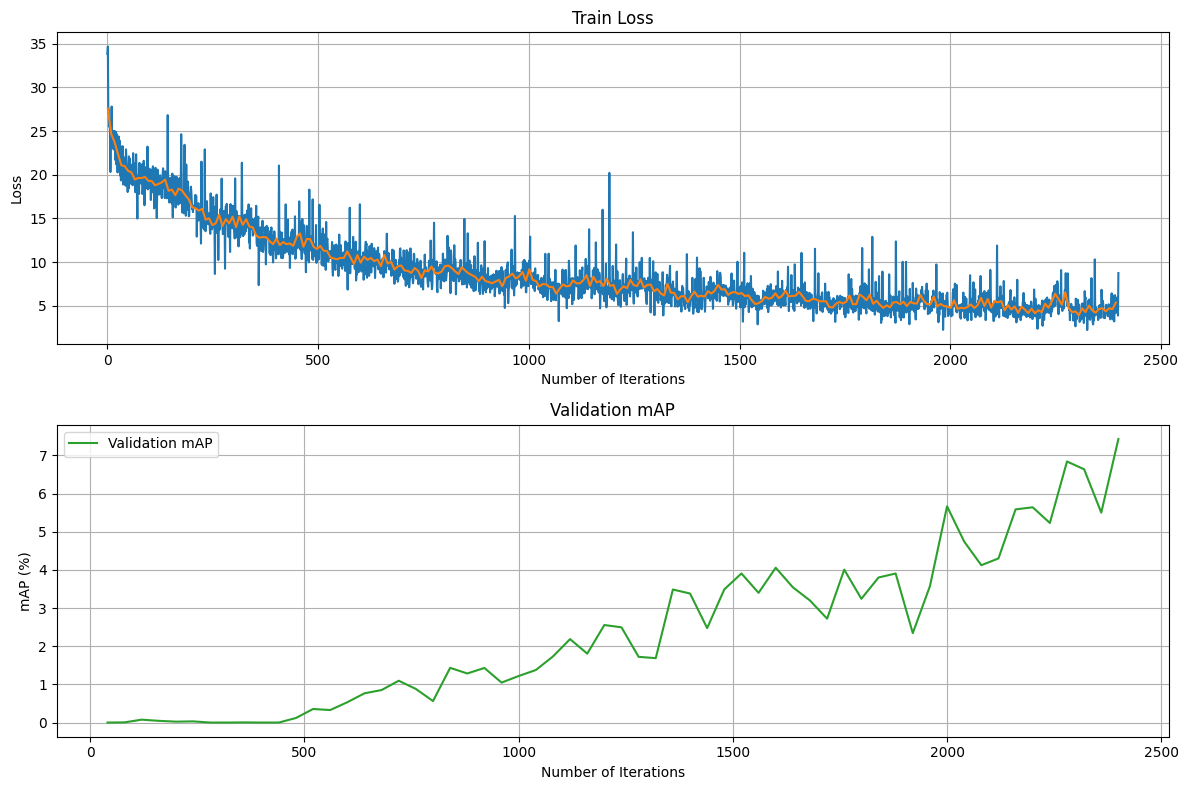

In [ ]:
runner.plot_loss(row_figsize=4)

In [ ]:
def print_training_summary(runner):
    print("\nTraining Results Summary:")
    print("-" * 60)
    print(f"{'Epoch':<8} | {'Train Loss':<12} | {'Val mAP (%)':<12} | {'LR':<12}")
    print("-" * 60)

    # Создаем словарь валидационных метрик
    val_metrics = {}
    if runner.val_metric:
        val_epochs = range(runner.val_every, len(runner.epoch_loss)+1, runner.val_every)
        val_metrics = dict(zip(val_epochs, [m*100 for m in runner.val_metric]))

    for epoch, loss in enumerate(runner.epoch_loss, 1):
        # Получаем значение mAP для текущей эпохи
        val_map = val_metrics.get(epoch)

        # Получаем learning rate
        lr = runner.optimizer.param_groups[0]['lr']

        # Форматируем вывод
        val_display = "N/A" if val_map is None else f"{val_map:.2f}"
        print(f"{epoch:<8} | {loss:<12.4f} | {val_display:<12} | {lr:<12.2e}")

        # Эмулируем шаг шедулера для правильного отображения LR
        if epoch < len(runner.epoch_loss) and runner.scheduler:
            runner.scheduler.step()

print_training_summary(runner)


Training Results Summary:
------------------------------------------------------------
Epoch    | Train Loss   | Val mAP (%)  | LR          
------------------------------------------------------------
1        | 27.5721      | N/A          | 1.00e-03    
2        | 24.6705      | N/A          | 9.77e-04    
3        | 23.7090      | N/A          | 9.09e-04    
4        | 22.3721      | N/A          | 8.04e-04    
5        | 21.0842      | 0.00         | 6.72e-04    
6        | 20.9717      | N/A          | 5.25e-04    
7        | 20.4442      | N/A          | 3.78e-04    
8        | 20.2557      | N/A          | 2.46e-04    
9        | 19.4476      | N/A          | 1.41e-04    
10       | 19.6287      | 0.00         | 7.32e-05    
11       | 19.6192      | N/A          | 5.00e-05    
12       | 19.7453      | N/A          | 7.32e-05    
13       | 19.3035      | N/A          | 1.41e-04    
14       | 19.2797      | N/A          | 2.46e-04    
15       | 18.7947      | 0.08         | 

In [ ]:
 torch.save(model, open("./detector", 'wb'))

In [ ]:
@torch.no_grad()
def predict(model, images, device, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type='list'):
    """ Предсказание моделью для переданного набора изображений после фильтрации по score_threshold
    и применения NMS.

    Параметры
    --------
    images : torch.tensor, содержащий картинки для которых нужно сделать предсказание.
    Необходимые преобразования должны быть сделаны ДО. Внутри метода `predict` никаких преобразований
    не происходит.
    score_threshold : Все предсказания, с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.

    Returns
    -------
    final_predictions : List[dict], где каждый словарь содержащий следующие ключи:
        "boxes" : координаты ббоксов на i-ом изображении,
        "labels" : классы внутри ббоксов,
        "scores" : Confidence scores для ббоксов.
    """
    model.eval()
    images = images.to(device)
    outputs = model(images)
    final_predictions =  _filter_predictions(outputs, score_threshold=score_threshold, nms_threshold=nms_threshold,
                                             max_boxes_per_cls=max_boxes_per_cls, return_type=return_type)
    return final_predictions

In [ ]:
def plot_predictions(images, predictions, figsize=(12, 3)):
    """ Рисуем по 3 предсказания на одной строке. """
    ncols = min(len(images), 3)
    for ix in range(0, len(images), ncols):
        _, axes = plt.subplots(1, ncols, figsize=figsize, tight_layout=True)
        for i, (ax, img) in enumerate(zip(axes, images[ix: ix+ncols])):
            img = img.cpu().permute(1, 2, 0).numpy()
            img = img * np.array(std).reshape(1, 1, -1) + np.array(mean).reshape(1, 1, -1)
            img = np.ascontiguousarray((img * 255).astype(np.uint8))
            preds = predictions[ix + i]
            for bbox, label, score in zip(preds["boxes"], preds["labels"], preds["scores"]):
                color = class_to_color[label+1]
                label = class_to_name[label+1]
                img = add_bbox(img, bbox, label=f"Class {label}: {score:.2f}", color=color)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    plt.close()

In [ ]:
test_iter = iter(test_dataloader)

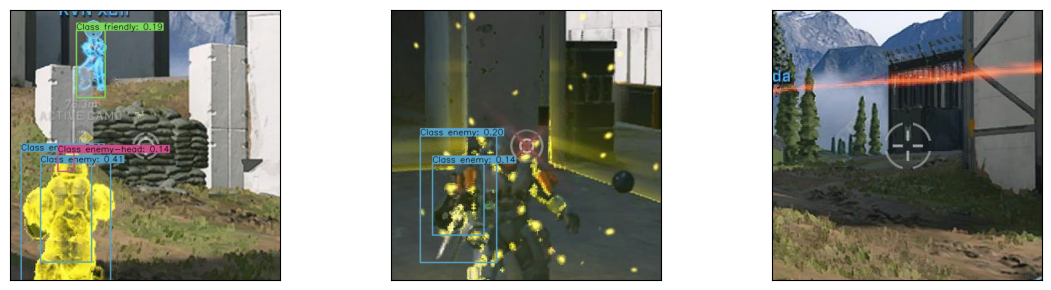

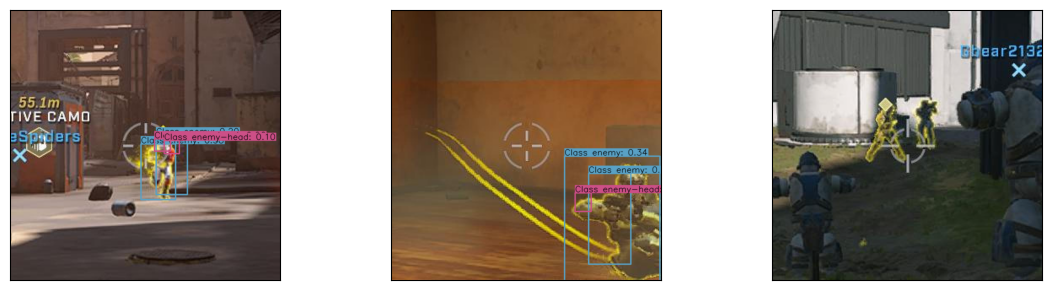

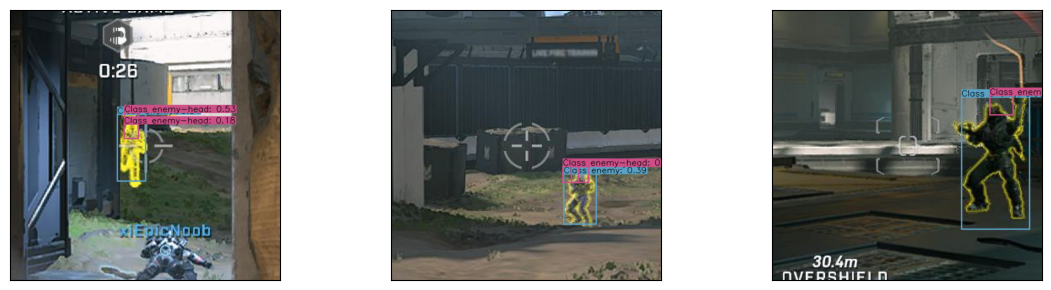

In [ ]:
score_threshold = 0.1
nms_threshold = 0.4

images, _ = next(test_iter)
preds = predict(model, images, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)
plot_predictions(images, preds)

In [ ]:
# В целом видно, что модель научилась определять персонажей, а также находить их головы. На пустых картинках персонажей не определяет.

In [ ]:
# Quality assessment
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

@torch.no_grad()
def compute_coco_map(model, dataloader, device, score_threshold=0.01, nms_threshold=0.5, num_classes=4):
    """ Считаем mAP модели на данных из `dataloader`. """
    model.eval()
    ann_id = 1
    all_detections = []
    all_gt_annotations = []
    images_info = []

    for images, targets in tqdm(dataloader, desc="Dataset Evaluation"):
        # Делаем предсказание для всех картинок в батче
        predictions = predict(model, images, device, score_threshold, nms_threshold)
        # Сохраняем изначальные картинки, предсказания и таргет в формате COCO
        for i in range(images.shape[0]):
            image_id = targets[i]["image_id"]
            images_info.append({
                "id": image_id,
                "width": images[i].shape[1],
                "height": images[i].shape[2]
            })

            # Сохраняем предсказания модели в формате COCO
            img_pred = predictions[i]
            for box, cls, sc in zip(img_pred["boxes"], img_pred["labels"], img_pred["scores"]):
                detection = {
                    "image_id": image_id,
                    "category_id": cls + 1,  # Классы в COCO начинаются с 1
                    "bbox": list(box),  # Бокс в COCO формате [x, y, w, h]
                    "score": sc
                }
                all_detections.append(detection)

            # Сохраняем таргет в формате COCO
            gt_boxes = targets[i]['boxes'].cpu().numpy().tolist()
            gt_labels = targets[i]['labels'].cpu().numpy().tolist()
            for box, label in zip(gt_boxes, gt_labels):
                gt_annotation = {
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": label + 1,
                    "bbox": box,
                    "area": box[2] * box[3],
                    "iscrowd": 0
                }
                all_gt_annotations.append(gt_annotation)
                ann_id += 1

    coco_gt_dict = {
        "images": images_info,
        "annotations": all_gt_annotations,
        "categories": [{"id": i+1, "name": f"class_{i}"} for i in range(model.num_classes)]
    }

    coco_gt = COCO()
    coco_gt.dataset = coco_gt_dict
    coco_gt.createIndex()

    coco_dt = coco_gt.loadRes(all_detections)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    overall_mAP = coco_eval.stats[0]
    print(f"Validation mAP: {overall_mAP:.4f}\n\n")

    class_maps = {}
    for cat_id in range(1, num_classes + 1):
        class_name = class_to_name[cat_id]
        print(f"\nmAP for class {class_name}")
        print("-" * 50)
        coco_eval_cat = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval_cat.params.catIds = [cat_id]
        coco_eval_cat.params.imgIds = coco_gt.getImgIds(catIds=[cat_id])
        coco_eval_cat.evaluate()
        coco_eval_cat.accumulate()
        coco_eval_cat.summarize();
        ap = coco_eval_cat.stats[0]
        class_maps[cat_id] = ap

In [ ]:
score_threshold = 0.1
nms_threshold = 0.5
compute_coco_map(model, test_dataloader, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)

Dataset Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.103
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.128
 Average Recall     (AR) @[ IoU=0.5

# Результат с TAL_assigner:


![image.png](attachment:7640dcd9-9297-444a-b5f0-838b1c8c56f1.png)

Training Results Summary:
------------------------------------------------------------
Epoch    | Train Loss   | Val mAP (%)  | LR          
------------------------------------------------------------
1        | 31.8614      | N/A          | 5.00e-05    
2        | 26.4547      | N/A          | 7.32e-05    
3        | 25.1718      | N/A          | 1.41e-04    
4        | 23.7862      | N/A          | 2.46e-04    
5        | 22.6208      | 0.06         | 3.78e-04    
6        | 22.5521      | N/A          | 5.25e-04    
7        | 22.1273      | N/A          | 6.72e-04    
8        | 21.0264      | N/A          | 8.04e-04    
9        | 22.0169      | N/A          | 9.09e-04    
10       | 21.0837      | 0.01         | 9.77e-04    
11       | 20.9177      | N/A          | 1.00e-03    
12       | 20.4454      | N/A          | 9.77e-04    
13       | 21.2183      | N/A          | 9.09e-04    
14       | 21.2069      | N/A          | 8.04e-04    
15       | 20.1850      | 0.02         | 6.72e-04    
16       | 21.7967      | N/A          | 5.25e-04    
17       | 20.4610      | N/A          | 3.78e-04    
18       | 19.7004      | N/A          | 2.46e-04    
19       | 19.7664      | N/A          | 1.41e-04    
20       | 18.9547      | 0.01         | 7.32e-05    
21       | 18.4042      | N/A          | 5.00e-05    
22       | 17.9745      | N/A          | 7.32e-05    
23       | 18.1572      | N/A          | 1.41e-04    
24       | 16.6721      | N/A          | 2.46e-04    
25       | 17.8972      | 0.03         | 3.78e-04    
26       | 15.8954      | N/A          | 5.25e-04    
27       | 17.0557      | N/A          | 6.72e-04    
28       | 16.0309      | N/A          | 8.04e-04    
29       | 15.9981      | N/A          | 9.09e-04    
30       | 16.3290      | 0.03         | 9.77e-04    
31       | 15.3331      | N/A          | 1.00e-03    
32       | 15.5542      | N/A          | 9.77e-04    
33       | 15.3284      | N/A          | 9.09e-04    
34       | 14.6781      | N/A          | 8.04e-04    
35       | 14.6597      | 0.01         | 6.72e-04    
36       | 14.3148      | N/A          | 5.25e-04    
37       | 14.1896      | N/A          | 3.78e-04    
38       | 14.8232      | N/A          | 2.46e-04    
39       | 14.9442      | N/A          | 1.41e-04    
40       | 14.7142      | 0.01         | 7.32e-05    
41       | 14.4147      | N/A          | 5.00e-05    
42       | 15.4755      | N/A          | 7.32e-05    
43       | 14.1531      | N/A          | 1.41e-04    
44       | 14.6620      | N/A          | 2.46e-04    
45       | 14.4228      | 0.01         | 3.78e-04    
46       | 13.1187      | N/A          | 5.25e-04    
47       | 13.2982      | N/A          | 6.72e-04    
48       | 12.2964      | N/A          | 8.04e-04    
49       | 12.6792      | N/A          | 9.09e-04    
50       | 13.4601      | 0.01         | 9.77e-04    
51       | 12.7104      | N/A          | 1.00e-03    
52       | 12.8262      | N/A          | 9.77e-04    
53       | 11.9408      | N/A          | 9.09e-04    
54       | 11.7528      | N/A          | 8.04e-04    
55       | 11.9195      | 0.01         | 6.72e-04    
56       | 11.5211      | N/A          | 5.25e-04    
57       | 12.1083      | N/A          | 3.78e-04    
58       | 11.6834      | N/A          | 2.46e-04    
59       | 11.8928      | N/A          | 1.41e-04    
60       | 12.8997      | 0.00         | 7.32e-05    
61       | 11.7760      | N/A          | 5.00e-05    
62       | 11.4192      | N/A          | 7.32e-05    
63       | 11.0601      | N/A          | 1.41e-04    
64       | 10.2795      | N/A          | 2.46e-04    
65       | 9.9131       | 0.00         | 3.78e-04    
66       | 10.6080      | N/A          | 5.25e-04    
67       | 10.6714      | N/A          | 6.72e-04    
68       | 11.3158      | N/A          | 8.04e-04    
69       | 9.5012       | N/A          | 9.09e-04    
70       | 10.4580      | 0.00         | 9.77e-04    
71       | 10.2006      | N/A          | 1.00e-03    
72       | 10.1240      | N/A          | 9.77e-04    
73       | 10.3621      | N/A          | 9.09e-04    
74       | 9.7487       | N/A          | 8.04e-04    
75       | 9.6982       | 0.00         | 6.72e-04    
76       | 10.5619      | N/A          | 5.25e-04    
77       | 9.9247       | N/A          | 3.78e-04    
78       | 9.5137       | N/A          | 2.46e-04    
79       | 9.3207       | N/A          | 1.41e-04    
80       | 10.4235      | 0.00         | 7.32e-05    
81       | 10.2021      | N/A          | 5.00e-05    
82       | 10.4971      | N/A          | 7.32e-05    
83       | 10.1113      | N/A          | 1.41e-04    
84       | 9.9858       | N/A          | 2.46e-04    
85       | 8.7265       | 0.00         | 3.78e-04    
86       | 9.8570       | N/A          | 5.25e-04    
87       | 9.3264       | N/A          | 6.72e-04    
88       | 9.1586       | N/A          | 8.04e-04    
89       | 9.2901       | N/A          | 9.09e-04    
90       | 9.0695       | 0.00         | 9.77e-04    
91       | 8.9173       | N/A          | 1.00e-03    
92       | 8.3854       | N/A          | 9.77e-04    
93       | 8.9260       | N/A          | 9.09e-04    
94       | 8.1379       | N/A          | 8.04e-04    
95       | 8.3676       | 0.00         | 6.72e-04    
96       | 8.5788       | N/A          | 5.25e-04    
97       | 8.6084       | N/A          | 3.78e-04    
98       | 9.2618       | N/A          | 2.46e-04    
99       | 8.5940       | N/A          | 1.41e-04    
100      | 8.0907       | 0.00         | 7.32e-05    
101      | 8.8953       | N/A          | 5.00e-05    
102      | 8.6978       | N/A          | 7.32e-05    
103      | 9.0148       | N/A          | 1.41e-04    
104      | 8.3169       | N/A          | 2.46e-04    
105      | 7.9869       | 0.00         | 3.78e-04    
106      | 7.6953       | N/A          | 5.25e-04    
107      | 7.1607       | N/A          | 6.72e-04    
108      | 7.7803       | N/A          | 8.04e-04    
109      | 6.4424       | N/A          | 9.09e-04    
110      | 7.7944       | 0.00         | 9.77e-04    
111      | 7.2687       | N/A          | 1.00e-03    
112      | 7.3919       | N/A          | 9.77e-04    
113      | 7.3494       | N/A          | 9.09e-04    
114      | 6.8941       | N/A          | 8.04e-04    
115      | 7.0930       | 0.00         | 6.72e-04    
116      | 7.5804       | N/A          | 5.25e-04    
117      | 6.8755       | N/A          | 3.78e-04    
118      | 7.5749       | N/A          | 2.46e-04    
119      | 7.1718       | N/A          | 1.41e-04    
120      | 7.3826       | 0.00         | 7.32e-05    
121      | 7.8613       | N/A          | 5.00e-05    
122      | 7.2798       | N/A          | 7.32e-05    
123      | 8.4812       | N/A          | 1.41e-04    
124      | 7.5647       | N/A          | 2.46e-04    
125      | 7.8145       | 0.00         | 3.78e-04    
126      | 8.2856       | N/A          | 5.25e-04    
127      | 6.9270       | N/A          | 6.72e-04    
128      | 6.7397       | N/A          | 8.04e-04    
129      | 6.8039       | N/A          | 9.09e-04    
130      | 6.6237       | 0.01         | 9.77e-04    
131      | 6.2972       | N/A          | 1.00e-03    
132      | 6.1115       | N/A          | 9.77e-04    
133      | 6.3706       | N/A          | 9.09e-04    
134      | 6.2425       | N/A          | 8.04e-04    
135      | 6.7753       | 0.00         | 6.72e-04    
136      | 6.7780       | N/A          | 5.25e-04    
137      | 7.4258       | N/A          | 3.78e-04    
138      | 6.3168       | N/A          | 2.46e-04    
139      | 6.4742       | N/A          | 1.41e-04    
140      | 7.0071       | 0.02         | 7.32e-05    
141      | 7.0492       | N/A          | 5.00e-05    
142      | 6.3371       | N/A          | 7.32e-05    
143      | 6.5990       | N/A          | 1.41e-04    
144      | 6.7231       | N/A          | 2.46e-04    
145      | 6.6018       | 0.01         | 3.78e-04    
146      | 6.7003       | N/A          | 5.25e-04    
147      | 5.7371       | N/A          | 6.72e-04    
148      | 5.9306       | N/A          | 8.04e-04    
149      | 5.7365       | N/A          | 9.09e-04    
150      | 5.9604       | 0.00         | 9.77e-04    

## Label assignment [2]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [ ]:
# def TAL_assigner(...):
#     # YOUR CODE HERE!

# Код данной функции был представлен ранее, сразу после assign_target.

### DIoU [1]

Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>

Для его реализации разобъем задачу на части:

**1. Реализуем IoU:**

Пусть даны координаты для предсказанного ($B^p$) и истинного ($B^g$) ббоксов в формате XYXY или VOC PASCAL (левый верхний и правый нижний углы):

$B^p=(x^p_1, y^p_1, x^p_2, y^p_2)$, $B^g=(x^g_1, y^g_1, x^g_2, y^g_2)$, тогда алгоритм расчета будет следующий:

    1. Найдем площади обоих ббоксов:
$$ A^p = (x^p_2 - x^p_1) * (y^p_2 - y^p_1) $$
$$ A^g = (x^g_2 - x^g_1) * (y^g_2 - y^g_1) $$

    2. Посчитаем пересечение между ббоксами:

Тут мы предлагаем вам подумать как в общем виде можно расчитать размеры ббокса, который будет являться пересечением $B^p$ и $B^g$, а затем посчитать его площадь:

$$x^I_1 = \qquad \qquad y^I_1 = $$
$$x^I_2 = \qquad \qquad y^I_2 = $$

В общем виде, площать будет записываться следующим образом:

Если $x^I_2 > x^I_1$ & $y^I_2 > y^I_1$, тогда:

$$I = (x^I_2 - x^I_1) * (y^I_2 - y^I_1)$$

Иначе, $I = 0$.

    3. Считаем объединение ббоксов.

Мы можем посчитать эту площадь как сумму площадей двух ббоксов минус площадь пересечения (тк мы считаем её два раз в сумме площадей):

$$U = A^p + A^g - I$$

    4. Вычисляем IoU.

$$IoU = \frac{I}{U}$$

**2. Рассчитаем площадь выпуклой оболочки:**

Для расчета площади, сначала выпишите координаты верхнего левого и правого нижнего углов. Подумайте, чему будут равны эти координаты в общем случае?

$$x^С_1 = \qquad \qquad y^С_1 = $$
$$x^С_2 = \qquad \qquad y^С_2 = $$

Подсказка: Нарисуйте несколько вариантов пересечений предсказания и GT на бумажке, и выпишите координаты для выпуклой оболочки.

$$C = (x^C_2 - x^C_1) * (y^C_2 - y^C_1)$$

**3. Рассчитаем расстояние между цетрами ббоксов:**

Сначала находим координаты центров каждого из ббоксов (если ббоксы в формате YOLO, то и считать ничего не нужно), затем считаем Евклидово расстояние между центрами.

$d = $

Собираем все части вместе и считаем лосс по формуле:

$$ DIoU = 1 - IoU + \frac{d^2}{C^2}$$

Помните, что пар ббоксов может быть много! Возвращайте усредненное значение лосса.

In [ ]:
from torchvision.ops import distance_box_iou_loss

In [ ]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)

In [ ]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [ ]:
print(f" DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean").item()}")

In [ ]:
def diou_loss(pred_boxes, gt_boxes):
  # TODO
  return

In [ ]:
import numpy as np
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(diou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean"))

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.15 mAP [1]
* 0.3 mAP [2]
* 0.6 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).
2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.
3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.
4. Добавьте аугментаций!

   Можно взять [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), библиотеку, которую мы использовали всеминаре. Или базовые аугментации из торча [тык](https://pytorch.org/vision/main/transforms.html). Если будете использовать торч, не забудте про ббоксы, transforms из коробки не будет их агументировать.
7. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).
8. Попробуйте заменить NMS на другой метод (WeightedNMS, SoftNMS, etc.). Немного ссылок:
    * Статья про SoftNMS [тык](https://arxiv.org/pdf/1704.04503)
    * Статья про WeightedNMS [тык](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w14/Zhou_CAD_Scale_Invariant_ICCV_2017_paper.pdf)
    * Есть их реализация, правда на нумбе [git](https://github.com/ZFTurbo/Weighted-Boxes-Fusion?tab=readme-ov-file)
10. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

In [ ]:

# Место для обучения, валидации и экспериментов!


Ниже определена вспомогательная функция для валидации качества. Можете использовать `Runner.validate`. Важное уточнение, ей нужен метод для фильтрации предсказаний. Можете тоже скопировать его из семинара, если он у вас не менялся.

In [ ]:
from torchmetrics.detection import MeanAveragePrecision

@torch.no_grad()
def validate(dataloader, filter_predictions_func, box_format="xyxy", device="cpu", score_threshold=0.1, nms_threshold=0.5, **kwargs):
    """ Метод для валидации модели.
    Возвращает mAP (0.5 ... 0.95).
    """
    self.model.eval()
    # Считаем метрику mAP с помощью функции из torchmetrics
    metric = MeanAveragePrecision(box_format=box_format, iou_type="bbox")
    for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
        images = images.to(device)
        outputs = self.model(images)
        predicts = filter_predictions_func(outputs, score_threshold, nms_threshold, **kwargs)
        metric.update(predicts, targets)
    return metric.compute()["map"].item()
